# Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_Learning-USU/blob/main/Lectures%20and%20codes/DL%20Spring%202023/Module%206-%20Deep%20Sequence%20Modeling/python/Module%206-%20Deep%20sequence%20modeling-RNN-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center) 


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 6- Deep Sequence Modeling (Part 1: RNN, LSTM)

This module provides a comprehensive overview of fundamental concepts and techniques related to deep sequence modeling. Part one explores deep learning for timeseries data, highlighting the inadequacy of DNN and CNN architectures for this task and introducing the recurrent neural network (RNN) as a solution. Part two delves into deep learning for natural language processing (NLP), illustrating how neural networks can be employed to process human language. The module concludes with a practical exercise in which students apply the concepts they have learned to build a deep sequence model and perform NLP tasks using TensorFlow in Python.

This notebook has been adapted from Deep learning with Python (2nd edition). Francois Chollet
https://github.com/fchollet/deep-learning-with-python-notebooks

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow https://www.tensorflow.org/install 



In [1]:
import tensorflow 
tensorflow.__version__

'2.11.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## A temperature-forecasting example

In [3]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-03-24 21:25:43--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.141.240, 52.216.52.232, 52.217.121.0, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.141.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.83MB/s    in 2.2s    

2023-03-24 21:25:46 (5.83 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [4]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))
print(lines[0:1])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30']


In [5]:
lines[0].split(",")[1:]


['996.52',
 '-8.02',
 '265.40',
 '-8.90',
 '93.30',
 '3.33',
 '3.11',
 '0.22',
 '1.94',
 '3.12',
 '1307.75',
 '1.03',
 '1.75',
 '152.30']

**Parsing the data**

In [6]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

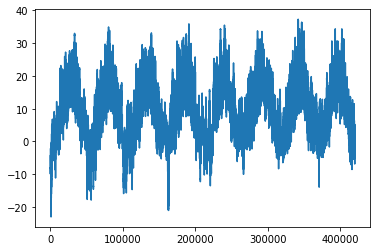

In [7]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

**Plotting the first 10 days of the temperature timeseries**

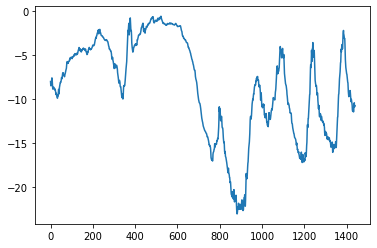

In [8]:
plt.plot(range(1440), temperature[:1440])
plt.show()

**Computing the number of samples we'll use for each data split**

In [9]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [10]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [11]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [19]:
for inputs, targets in dummy_dataset:
  print(inputs.shape)
  print(targets.shape)
  break

(2, 3)
(2,)


**Instantiating datasets for training, validation, and testing**

In [20]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [21]:
raw_data.shape

(420451, 14)

**Inspecting the output of one of our datasets**

In [41]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [42]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [45]:
raw_data.shape[-1]

14

In [46]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 54ms/step - loss: 11.8254 - mae: 2.6677 - val_loss: 11.5965 - val_mae: 2.7075
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 8.7901 - mae: 2.3243 - val_loss: 10.9332 - val_mae: 2.6126
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.1266 - mae: 2.2335 - val_loss: 10.0961 - val_mae: 2.5173
Epoch 4/10
819/819 [==============================] - 39s 47ms/step - loss: 7.7028 - mae: 2.1789 - val_loss: 10.0465 - val_mae: 2.5095
Epoch 5/10
819/819 [==============================] - 41s 49ms/step - loss: 7.3942 - mae: 2.1366 - val_loss: 10.3980 - val_mae: 2.5512
Epoch 6/10
819/819 [==============================] - 40s 48ms/step - loss: 7.1723 - mae: 2.1046 - val_loss: 10.3051 - val_mae: 2.5363
Epoch 7/10
819/819 [==============================] - 39s 48ms/step - loss: 6.9759 - mae: 2.0743 - val_loss: 11.7908 - val_mae: 2.7168
Epoch 8/10
819/819 [==============================] - 

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 16)                26896     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [47]:
120*14

1680

**Plotting results**

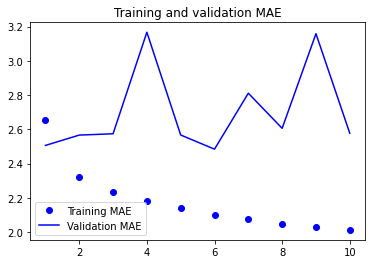

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 57s 61ms/step - loss: 24.1514 - mae: 3.8238 - val_loss: 15.7429 - val_mae: 3.1395
Epoch 2/10
819/819 [==============================] - 44s 53ms/step - loss: 15.9866 - mae: 3.1749 - val_loss: 16.5178 - val_mae: 3.1897
Epoch 3/10
819/819 [==============================] - 41s 49ms/step - loss: 14.4446 - mae: 3.0113 - val_loss: 15.5678 - val_mae: 3.0989
Epoch 4/10
819/819 [==============================] - 42s 52ms/step - loss: 13.6409 - mae: 2.9236 - val_loss: 14.1449 - val_mae: 2.9750
Epoch 5/10
819/819 [==============================] - 42s 51ms/step - loss: 13.0285 - mae: 2.8536 - val_loss: 14.9943 - val_mae: 3.0369
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 12.4916 - mae: 2.7958 - val_loss: 14.2077 - val_mae: 2.9765
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 12.0237 - mae: 2.7425 - val_loss: 16.7548 - val_mae: 3.2778
Epoch 8/10
819/819 [============================

In [49]:
24*14*8+8

2696

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 18, 8)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

### A first recurrent baseline

**A simple LSTM-based model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 55ms/step - loss: 48.4674 - mae: 5.0914 - val_loss: 13.9837 - val_mae: 2.8151
Epoch 2/10
819/819 [==============================] - 44s 54ms/step - loss: 11.2524 - mae: 2.5961 - val_loss: 9.7996 - val_mae: 2.4357
Epoch 3/10
819/819 [==============================] - 52s 63ms/step - loss: 9.7709 - mae: 2.4301 - val_loss: 9.4297 - val_mae: 2.3923
Epoch 4/10
819/819 [==============================] - 45s 55ms/step - loss: 9.2783 - mae: 2.3669 - val_loss: 9.5730 - val_mae: 2.4146
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 8.8364 - mae: 2.3130 - val_loss: 9.6365 - val_mae: 2.4201
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 8.5151 - mae: 2.2737 - val_loss: 9.8357 - val_mae: 2.4431
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 8.3595 - mae: 2.2540 - val_loss: 9.8285 - val_mae: 2.4461
Epoch 8/10
819/819 [==============================] - 52s 6

In [53]:
4*((14*16) + (16*16) + 16 )

1984

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 372s 444ms/step - loss: 29.7784 - mae: 4.0097 - val_loss: 10.1374 - val_mae: 2.4697
Epoch 2/10
819/819 [==============================] - 359s 439ms/step - loss: 15.0145 - mae: 3.0107 - val_loss: 9.4481 - val_mae: 2.3882
Epoch 3/10
819/819 [==============================] - 359s 438ms/step - loss: 14.1408 - mae: 2.9171 - val_loss: 9.5654 - val_mae: 2.4035
Epoch 4/10
819/819 [==============================] - 360s 439ms/step - loss: 13.5090 - mae: 2.8465 - val_loss: 9.4529 - val_mae: 2.3922
Epoch 5/10
819/819 [==============================] - 360s 439ms/step - loss: 13.0500 - mae: 2.7985 - val_loss: 9.2185 - val_mae: 2.3551
Epoch 6/10
819/819 [==============================] - 359s 438ms/step - loss: 12.5901 - mae: 2.7481 - val_loss: 9.3739 - val_mae: 2.3797
Epoch 7/10
819/819 [==============================] - 360s 439ms/step - loss: 12.2703 - mae: 2.7147 - val_loss: 9.2219 - val_mae: 2.3670
Epoch 8/10
819/819 [====================

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 669s 811ms/step - loss: 25.6497 - mae: 3.7403 - val_loss: 9.3648 - val_mae: 2.3650
Epoch 2/10
819/819 [==============================] - 659s 805ms/step - loss: 14.1352 - mae: 2.9137 - val_loss: 8.9392 - val_mae: 2.3271
Epoch 3/10
819/819 [==============================] - 666s 813ms/step - loss: 13.2090 - mae: 2.8151 - val_loss: 9.0947 - val_mae: 2.3395
Epoch 4/10
819/819 [==============================] - 663s 810ms/step - loss: 12.5230 - mae: 2.7470 - val_loss: 8.9057 - val_mae: 2.3210
Epoch 5/10
819/819 [==============================] - 667s 815ms/step - loss: 12.0968 - mae: 2.6987 - val_loss: 8.9120 - val_mae: 2.3333
Epoch 6/10
819/819 [==============================] - 666s 812ms/step - loss: 11.5912 - mae: 2.6436 - val_loss: 8.9627 - val_mae: 2.3353
Epoch 7/10
819/819 [==============================] - 665s 812ms/step - loss: 11.2435 - mae: 2.6011 - val_loss: 9.6596 - val_mae: 2.4278
Epoch 8/10
297/819 [=========>...........

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 54s 61ms/step - loss: 25.8363 - mae: 3.6455 - val_loss: 10.3662 - val_mae: 2.5031
Epoch 2/10
819/819 [==============================] - 48s 59ms/step - loss: 9.4510 - mae: 2.4081 - val_loss: 10.2767 - val_mae: 2.4950
Epoch 3/10
819/819 [==============================] - 48s 59ms/step - loss: 8.4728 - mae: 2.2780 - val_loss: 10.1487 - val_mae: 2.4741
Epoch 4/10
819/819 [==============================] - 48s 59ms/step - loss: 7.8908 - mae: 2.1930 - val_loss: 10.5334 - val_mae: 2.5171
Epoch 5/10
819/819 [==============================] - 49s 59ms/step - loss: 7.4825 - mae: 2.1318 - val_loss: 10.4695 - val_mae: 2.5139
Epoch 6/10
819/819 [==============================] - 48s 59ms/step - loss: 7.1763 - mae: 2.0855 - val_loss: 10.6798 - val_mae: 2.5241
Epoch 7/10
819/819 [==============================] - 49s 60ms/step - loss: 6.8732 - mae: 2.0386 - val_loss: 10.4041 - val_mae: 2.5086
Epoch 8/10
819/819 [==============================] - 

In [ ]:
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 16s 38ms/step - loss: 12.6675 - mae: 2.7561
Test MAE: 2.76


Done!